# **Loan Default Prediction**

## **Problem Definition**

### **The Context:**

 - For hundreds of years, one of a banks purposes was to allow individuals the ability to borrow money that they currently did not have in order to use it towards things that they needed/wanted (example: house, cars, land, etc). The idea was that the individual would pay back the bank overtime with intertest, which is how banks made money on these loans. However, many individuals with bad financial planning end up having no money to pay off these loans which leads to the bank not getting their money back. Overtime, rules and regualtions have been made in order to help banks determine who they should be giving out loans too. This process quite extensive and is prone to wrong judgment/approval owing to human error or biases.

### **The objective:**

 - The objective is to simplify this extensive loan acceptance process by developing a model that can predict clients who are most likely to default on their loan as well as give insights to the bank as to what the important features are that correlate to someone who might default. This will in turn reduce the number of defaults the bank has and thus save them money and reduce risk.

### **The key questions:**

- What individual features correlate to loan defaults?

- which features have the highest impact to loan defaults?

- Which performance metrics do i want to use in order to valuate the success of the model?

### **The problem formulation**:

- The model needs to predict whether someone will default on their loan or not given various inputs from data gathered by the bank. Also, the model needs to identify important factors that contribute to loan defaulting.

## **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property.

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts)

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments).

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due).

* **CLAGE:** Age of the oldest credit line in months.

* **NINQ:** Number of recent credit inquiries.

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and Data**

In [1]:
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# To build model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# Metrics to evaluate the model
from sklearn import metrics
# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

In [3]:
hm=pd.read_csv("data/hmeq.csv")

In [4]:
# Copying data to another variable to avoid any changes to original data
df_bank=hm.copy()

## Treating Missing Values

In [5]:
#Treat Missing values in numerical columns with median and mode in categorical variables
#Treating Categorical variables first with mode
categorical_cols = df_bank.select_dtypes(include=['object', 'category']).columns
df_bank[categorical_cols] = df_bank[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))
#Treating numerical values with median
numerical_cols = df_bank.select_dtypes(include=['number']).columns
df_bank[numerical_cols] = df_bank[numerical_cols].fillna(df_bank[numerical_cols].median())

In [6]:
df_bank.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.00000,39025.00000,HomeImp,Other,10.50000,0.00000,0.00000,94.36667,1.00000,9.00000,34.81826
1,1,1300,70053.00000,68400.00000,HomeImp,Other,7.00000,0.00000,2.00000,121.83333,0.00000,14.00000,34.81826
2,1,1500,13500.00000,16700.00000,HomeImp,Other,4.00000,0.00000,0.00000,149.46667,1.00000,10.00000,34.81826
3,1,1500,65019.00000,89235.50000,DebtCon,Other,7.00000,0.00000,0.00000,173.46667,1.00000,20.00000,34.81826
4,0,1700,97800.00000,112000.00000,HomeImp,Office,3.00000,0.00000,0.00000,93.33333,0.00000,14.00000,34.81826


In [7]:
df_bank.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

## **Model Building - Approach**
- Data preparation
- Partition the data into train and test set
- Build the model
- Fit on the train data
- Tune the model
- Test the model on test set

### Creating Dummy variables for categorical columns

In [8]:
# Creating a list of columns for which we will create dummy variables
to_get_dummies_for = ['REASON',"JOB"]

In [11]:
# Creating dummy variables
bank_Dummy = pd.get_dummies(data = df_bank, columns = to_get_dummies_for, drop_first = True)
dummy_cols = bank_Dummy.columns[bank_Dummy.columns.str.contains('|'.join(to_get_dummies_for))]
# Convert only the dummy columns to integers
bank_Dummy[dummy_cols] = bank_Dummy[dummy_cols].astype(int)



In [12]:
bank_Dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.00000,39025.00000,10.50000,0.00000,0.00000,94.36667,1.00000,9.00000,34.81826,1,0,1,0,0,0
1,1,1300,70053.00000,68400.00000,7.00000,0.00000,2.00000,121.83333,0.00000,14.00000,34.81826,1,0,1,0,0,0
2,1,1500,13500.00000,16700.00000,4.00000,0.00000,0.00000,149.46667,1.00000,10.00000,34.81826,1,0,1,0,0,0
3,1,1500,65019.00000,89235.50000,7.00000,0.00000,0.00000,173.46667,1.00000,20.00000,34.81826,0,0,1,0,0,0
4,0,1700,97800.00000,112000.00000,3.00000,0.00000,0.00000,93.33333,0.00000,14.00000,34.81826,1,1,0,0,0,0


In [14]:
# Separating the target variable and other variables

Y = bank_Dummy.BAD

X = bank_Dummy.drop(['BAD'], axis = 1)

### Splitting the data into 80% train and 20% test

In [55]:
# Splitting the data into a 80:20 ratio for train to test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)

In [91]:
# to validate and show the size of the train and test data sets
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (4768, 16)
Shape of test set :  (1192, 16)
Percentage of classes in training set:
BAD
0   0.80055
1   0.19945
Name: proportion, dtype: float64
Percentage of classes in test set:
BAD
0   0.80034
1   0.19966
Name: proportion, dtype: float64


 For both the test and training datasets it appears that individuals who did not default are much higher then those who did. I will probably weight the values to focus more on defaulted individuals.

### Logistic Regression

To Begin this process I will create a function to calculate and print the classification report and confusion matrix so that I don't have to rewrite the same code repeatedly for each model

In [57]:
# Creating metric function

def metrics_score(actual, predicted):

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Defaulted', 'Defaulted'], yticklabels = ['Not Defaulted', 'Defaulted'])
    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

In [58]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall

    precision = precision_score(target, pred, average = 'macro')              # To compute precision

    acc = accuracy_score(target, pred)                                 # To compute accuracy score


    # Creating a dataframe of metrics

    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },
        index = [0],
    )

    return df_perf

I will use the class_weight hyperparameter with the value equal to {0: 0.2, 1: 0.8} which is approximately the opposite of the imbalance in the original data.

This would tell the model that 1 is the important class here.

In [59]:
lg = LogisticRegression(class_weight={0: 0.2, 1: 0.8},)

In [60]:
lg.fit(x_train,y_train)

LogisticRegression(class_weight={0: 0.2, 1: 0.8})

              precision    recall  f1-score   support

           0       0.89      0.61      0.72      3817
           1       0.31      0.69      0.42       951

    accuracy                           0.63      4768
   macro avg       0.60      0.65      0.57      4768
weighted avg       0.77      0.63      0.66      4768



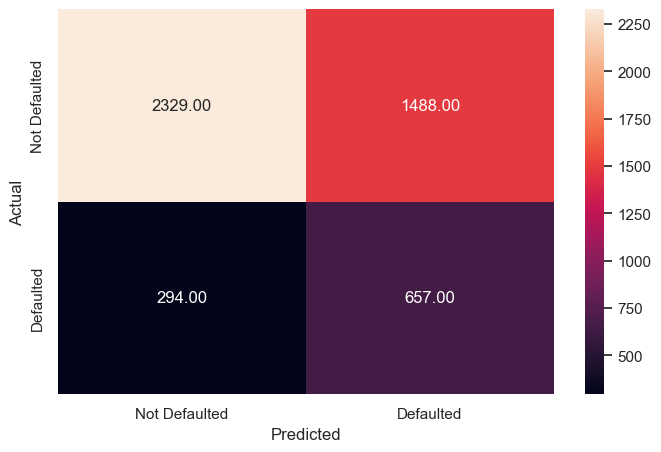

In [61]:
y_train_pred_dt = lg.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.88      0.60      0.71       954
           1       0.29      0.67      0.41       238

    accuracy                           0.61      1192
   macro avg       0.58      0.63      0.56      1192
weighted avg       0.76      0.61      0.65      1192



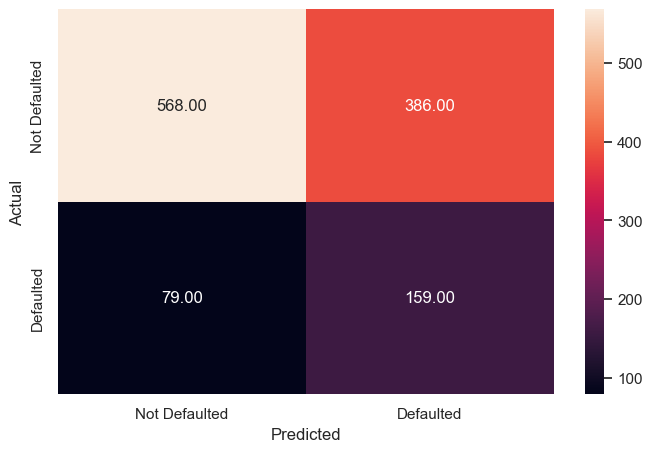

In [62]:
# Checking performance on the test dataset
y_test_pred_dt = lg.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [63]:
lg_model_Test = model_performance_classification(lg,x_test,y_test)
lg_model_Test

,Precision,Recall,Accuracy
0,0.58482,0.63173,0.60990


**Observations** The overall accuracy for the model is roughly 60% with a recall of 63%. However, when it comes to classifying defaulting individuals it did slightly better with a recall of 69%. Since predicting who will default is the main goal, we need to maximize our recall for individuals who will default (BAD = 1). However our precision for class1 is pretty low. Lets try and find a threshold that balances these out.

Checking the coefficients to find which variables are leading to defaulting and which can help to reduce defaults.

In [64]:
# Printing the coefficients of logistic regression
cols = X.columns

coef_lg = lg.coef_

pd.DataFrame(coef_lg,columns = cols).T.sort_values(by = 0, ascending = False)

,0
DELINQ,0.06607
DEBTINC,0.04646
NINQ,0.03681
DEROG,0.03554
REASON_HomeImp,0.00282
JOB_Self,0.00136
JOB_Sales,0.00104
JOB_Other,0.00091
VALUE,0.00000
MORTDUE,-0.00001


**Observations** Features which positively affect default rate are: DEBTINC,  CLNO, DELINQ, NINQ, DEROG, YOJ, JOB_Other, REASON_HomeImp, JOB_Sales, JOB_Self

Features which negatively affect default rate are: CLAGE, JOB_ProfExe, JOB_Office, LOAN,

VALUE and MORTDUE appear to have no impact to the default rate.

The Precision-Recall Curve for Logistic Regression to see if a different threshold should be used.

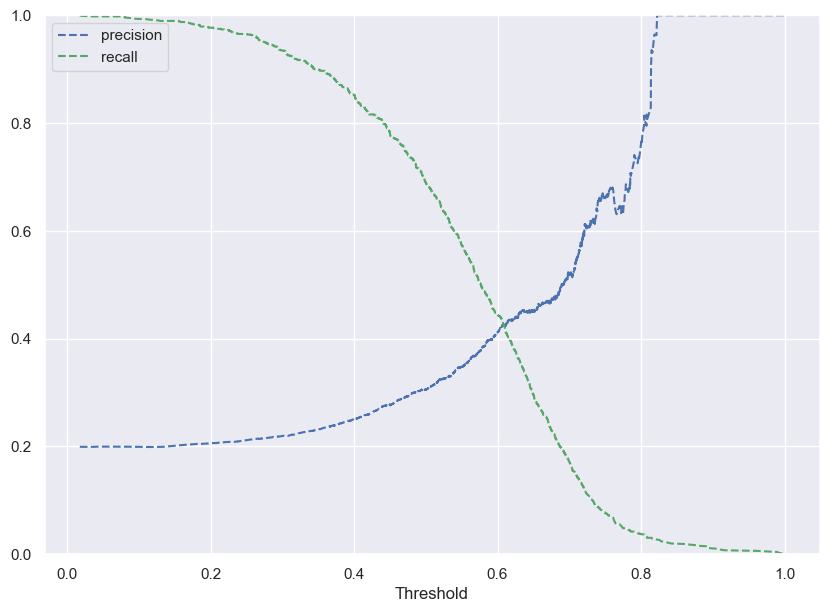

In [65]:
y_scores_lg = lg.predict_proba(x_train) # predict_proba gives the probability of each observation belonging to each class


precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:, 1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize = (10, 7))

plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label = 'precision')

plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')

plt.xlabel('Threshold')

plt.legend(loc = 'upper left')

plt.ylim([0, 1])

plt.show()

**Observations** By the graph the balance of precision and recall appear to be balanced at a threshold of about 0.6-0.63. This is what the default threshold is for the above model. I will set the threshold and re-train the model.

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3817
           1       0.43      0.42      0.42       951

    accuracy                           0.77      4768
   macro avg       0.64      0.64      0.64      4768
weighted avg       0.77      0.77      0.77      4768



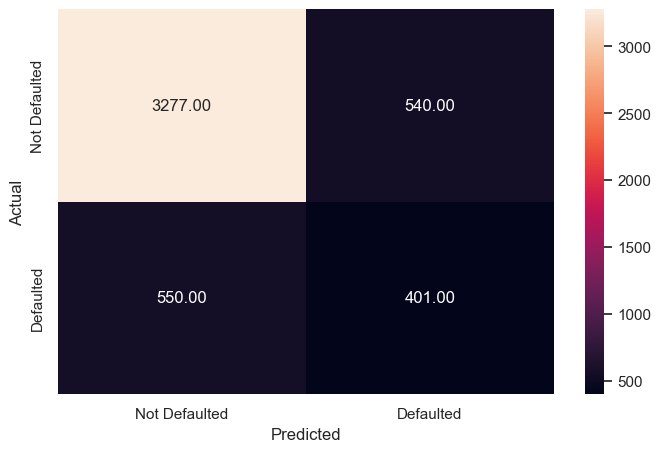

In [67]:
optimal_threshold1 = .61

y_pred_train = lg.predict_proba(x_train)

metrics_score(y_train, y_pred_train[:, 1] > optimal_threshold1)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       954
           1       0.40      0.39      0.39       238

    accuracy                           0.76      1192
   macro avg       0.63      0.62      0.62      1192
weighted avg       0.76      0.76      0.76      1192



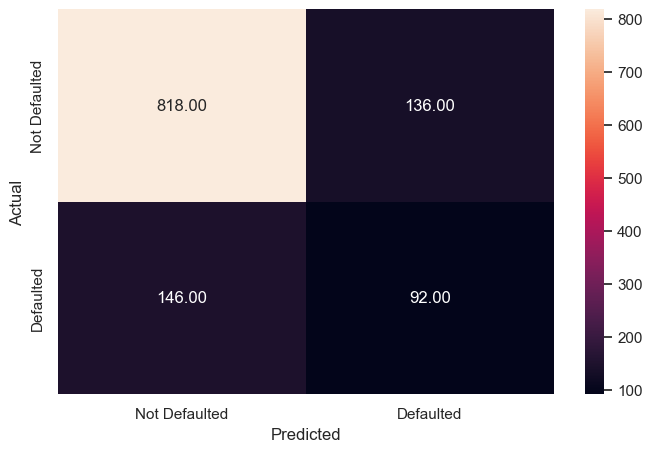

In [68]:
optimal_threshold1 = .61

y_pred_test = lg.predict_proba(x_test)

metrics_score(y_test, y_pred_test[:, 1] > optimal_threshold1)

**Observations:** Once the threshold was changed you can see that recall and precision hsa been more balanced out. This decreased our Recall for class 1 from 68% to 47%. The overall accuracy of the model has increased to 76% compared to the previous model of 61%. However, this will not do a good job at predicting who will default on their loans as that is the main goal fo the bank. I am going to now make the other models to see if we can get a better recall while maintaining a relativiley good precision value as well.

### Decision Tree

In [69]:
# Fitting the decision tree classifier on the training data
d_tree = DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8},)

d_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8})

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      1.00      1.00       951

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768



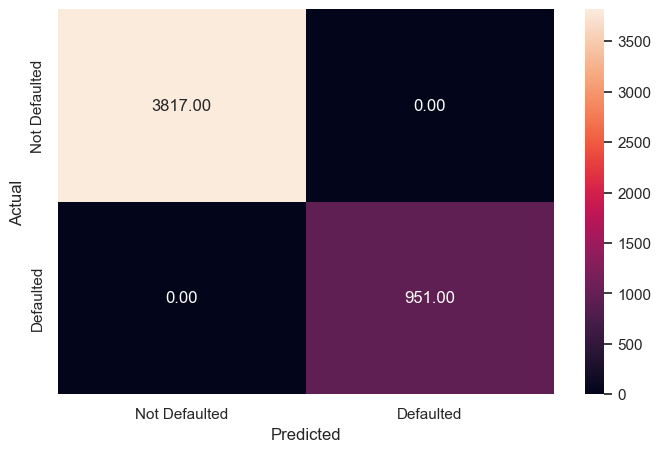

In [70]:
# Checking performance on the training dataset
y_train_pred_dt = d_tree.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

**Observations:** The Decision tree is giving a 100% score for all metrics on the training dataset

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       954
           1       0.69      0.61      0.65       238

    accuracy                           0.87      1192
   macro avg       0.80      0.77      0.78      1192
weighted avg       0.86      0.87      0.86      1192



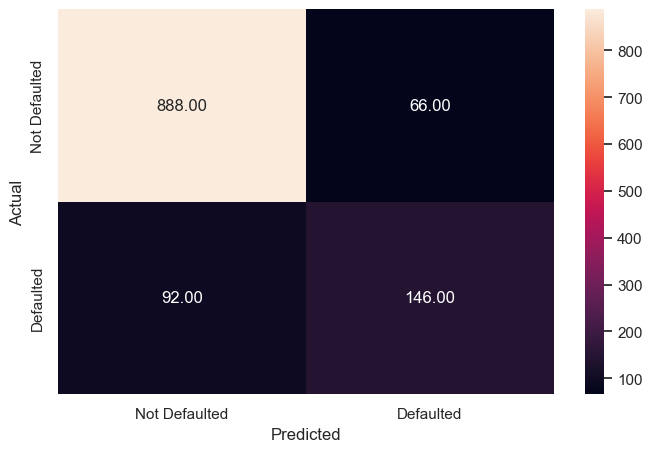

In [71]:
# Checking performance on the test dataset
y_test_pred_dt = d_tree.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [72]:
d_tree_test = model_performance_classification(d_tree,x_test,y_test)
d_tree_test

,Precision,Recall,Accuracy
0,0.79740,0.77213,0.86745


**Observations** Right out the gate the overall accuracy of the model is much higher then logistics regression with a 87% accuracy. However, our recall for class 1 is only 59%. It can also be seen that the training model was overfitting the data as the difference between the training performance and test performance are quite different.

### **Decision Tree - Hyperparameter Tuning**

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.**
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth**

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

You can learn about more Hyperpapameters on this link and try to tune them.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [73]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 10),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 50, 75]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, criterion='entropy',
                       max_depth=9, min_samples_leaf=50, random_state=1)

**Observations:** From the grid search results it can be seen that a max tree depth of 5 with min leaf sample of 10 is the ideal combination.

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      3817
           1       0.54      0.87      0.67       951

    accuracy                           0.83      4768
   macro avg       0.75      0.85      0.78      4768
weighted avg       0.88      0.83      0.84      4768



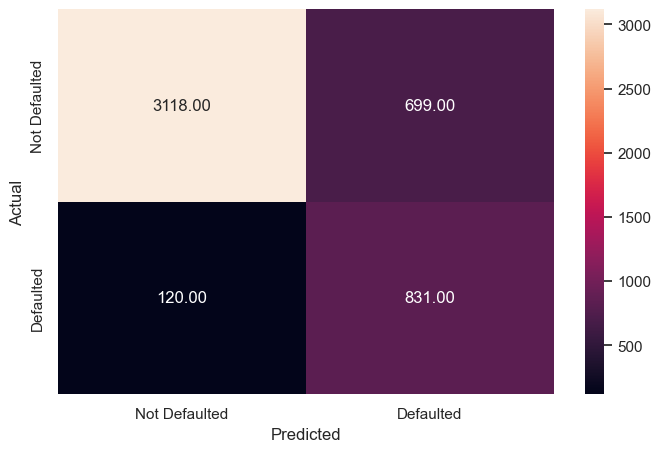

In [74]:
# Checking performance on the training dataset with hyper parameters
y_train_pred_est = dtree_estimator.predict(x_train)

metrics_score(y_train, y_train_pred_est)

**Observations:** From the output you can see that the performance on the training data has gone down. This is okay as we are trying to reduce overfitting

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       954
           1       0.52      0.81      0.63       238

    accuracy                           0.81      1192
   macro avg       0.73      0.81      0.75      1192
weighted avg       0.86      0.81      0.83      1192



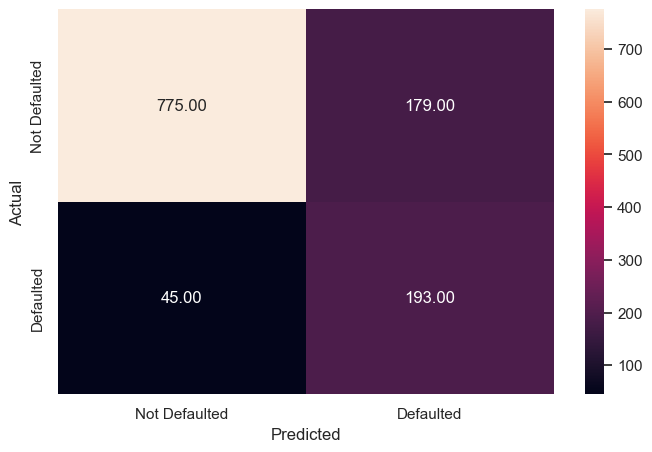

In [75]:
# Checking performance on the test dataset with hyperparameters
y_test_pred_est = dtree_estimator.predict(x_test)

metrics_score(y_test, y_test_pred_est)

In [76]:
dtree_estimator_test = model_performance_classification(dtree_estimator,x_test,y_test)
dtree_estimator_test

,Precision,Recall,Accuracy
0,0.73197,0.81165,0.81208


**Observations:** The overal accuracy has gone down slightly to 83% however overall recall as well as our class 1 recall has increased. With a class 1 recall of 78% that is currently the highest percentage of correct classification. I'll now break the tree down to see which features are of most importance.

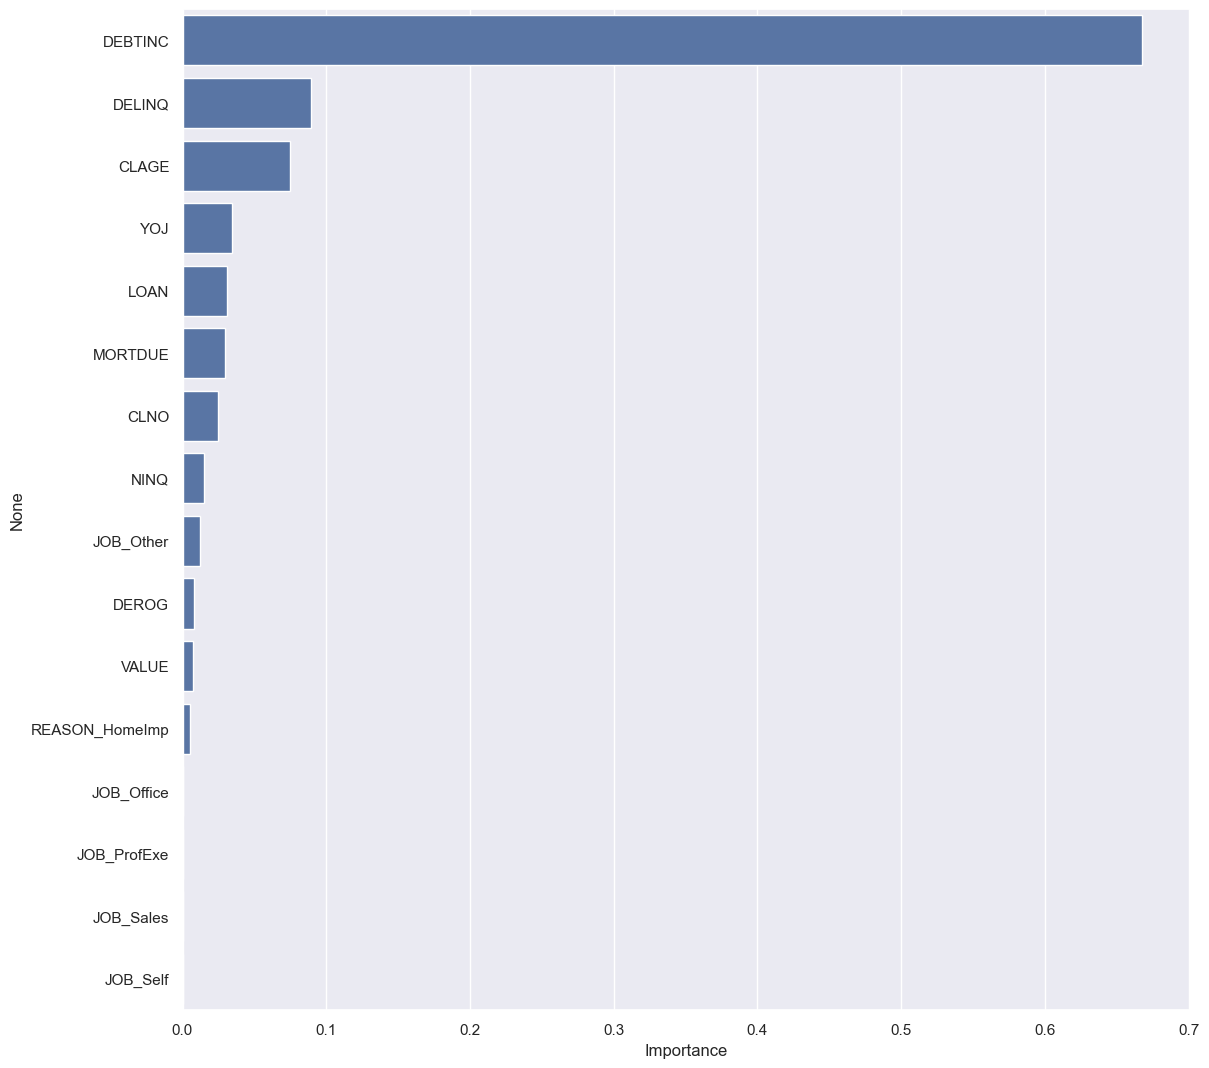

In [77]:
importances = dtree_estimator.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x=importance_df.Importance, y=importance_df.index);

**Observations:** It can be seen that Debt to income ratio trumps all other features when it comes to importance. This makes sense as this is what banks use as a measurement to determine is someone would be able to pay back a loan or not. Some other notable features would be DELINQ and CLAGE.

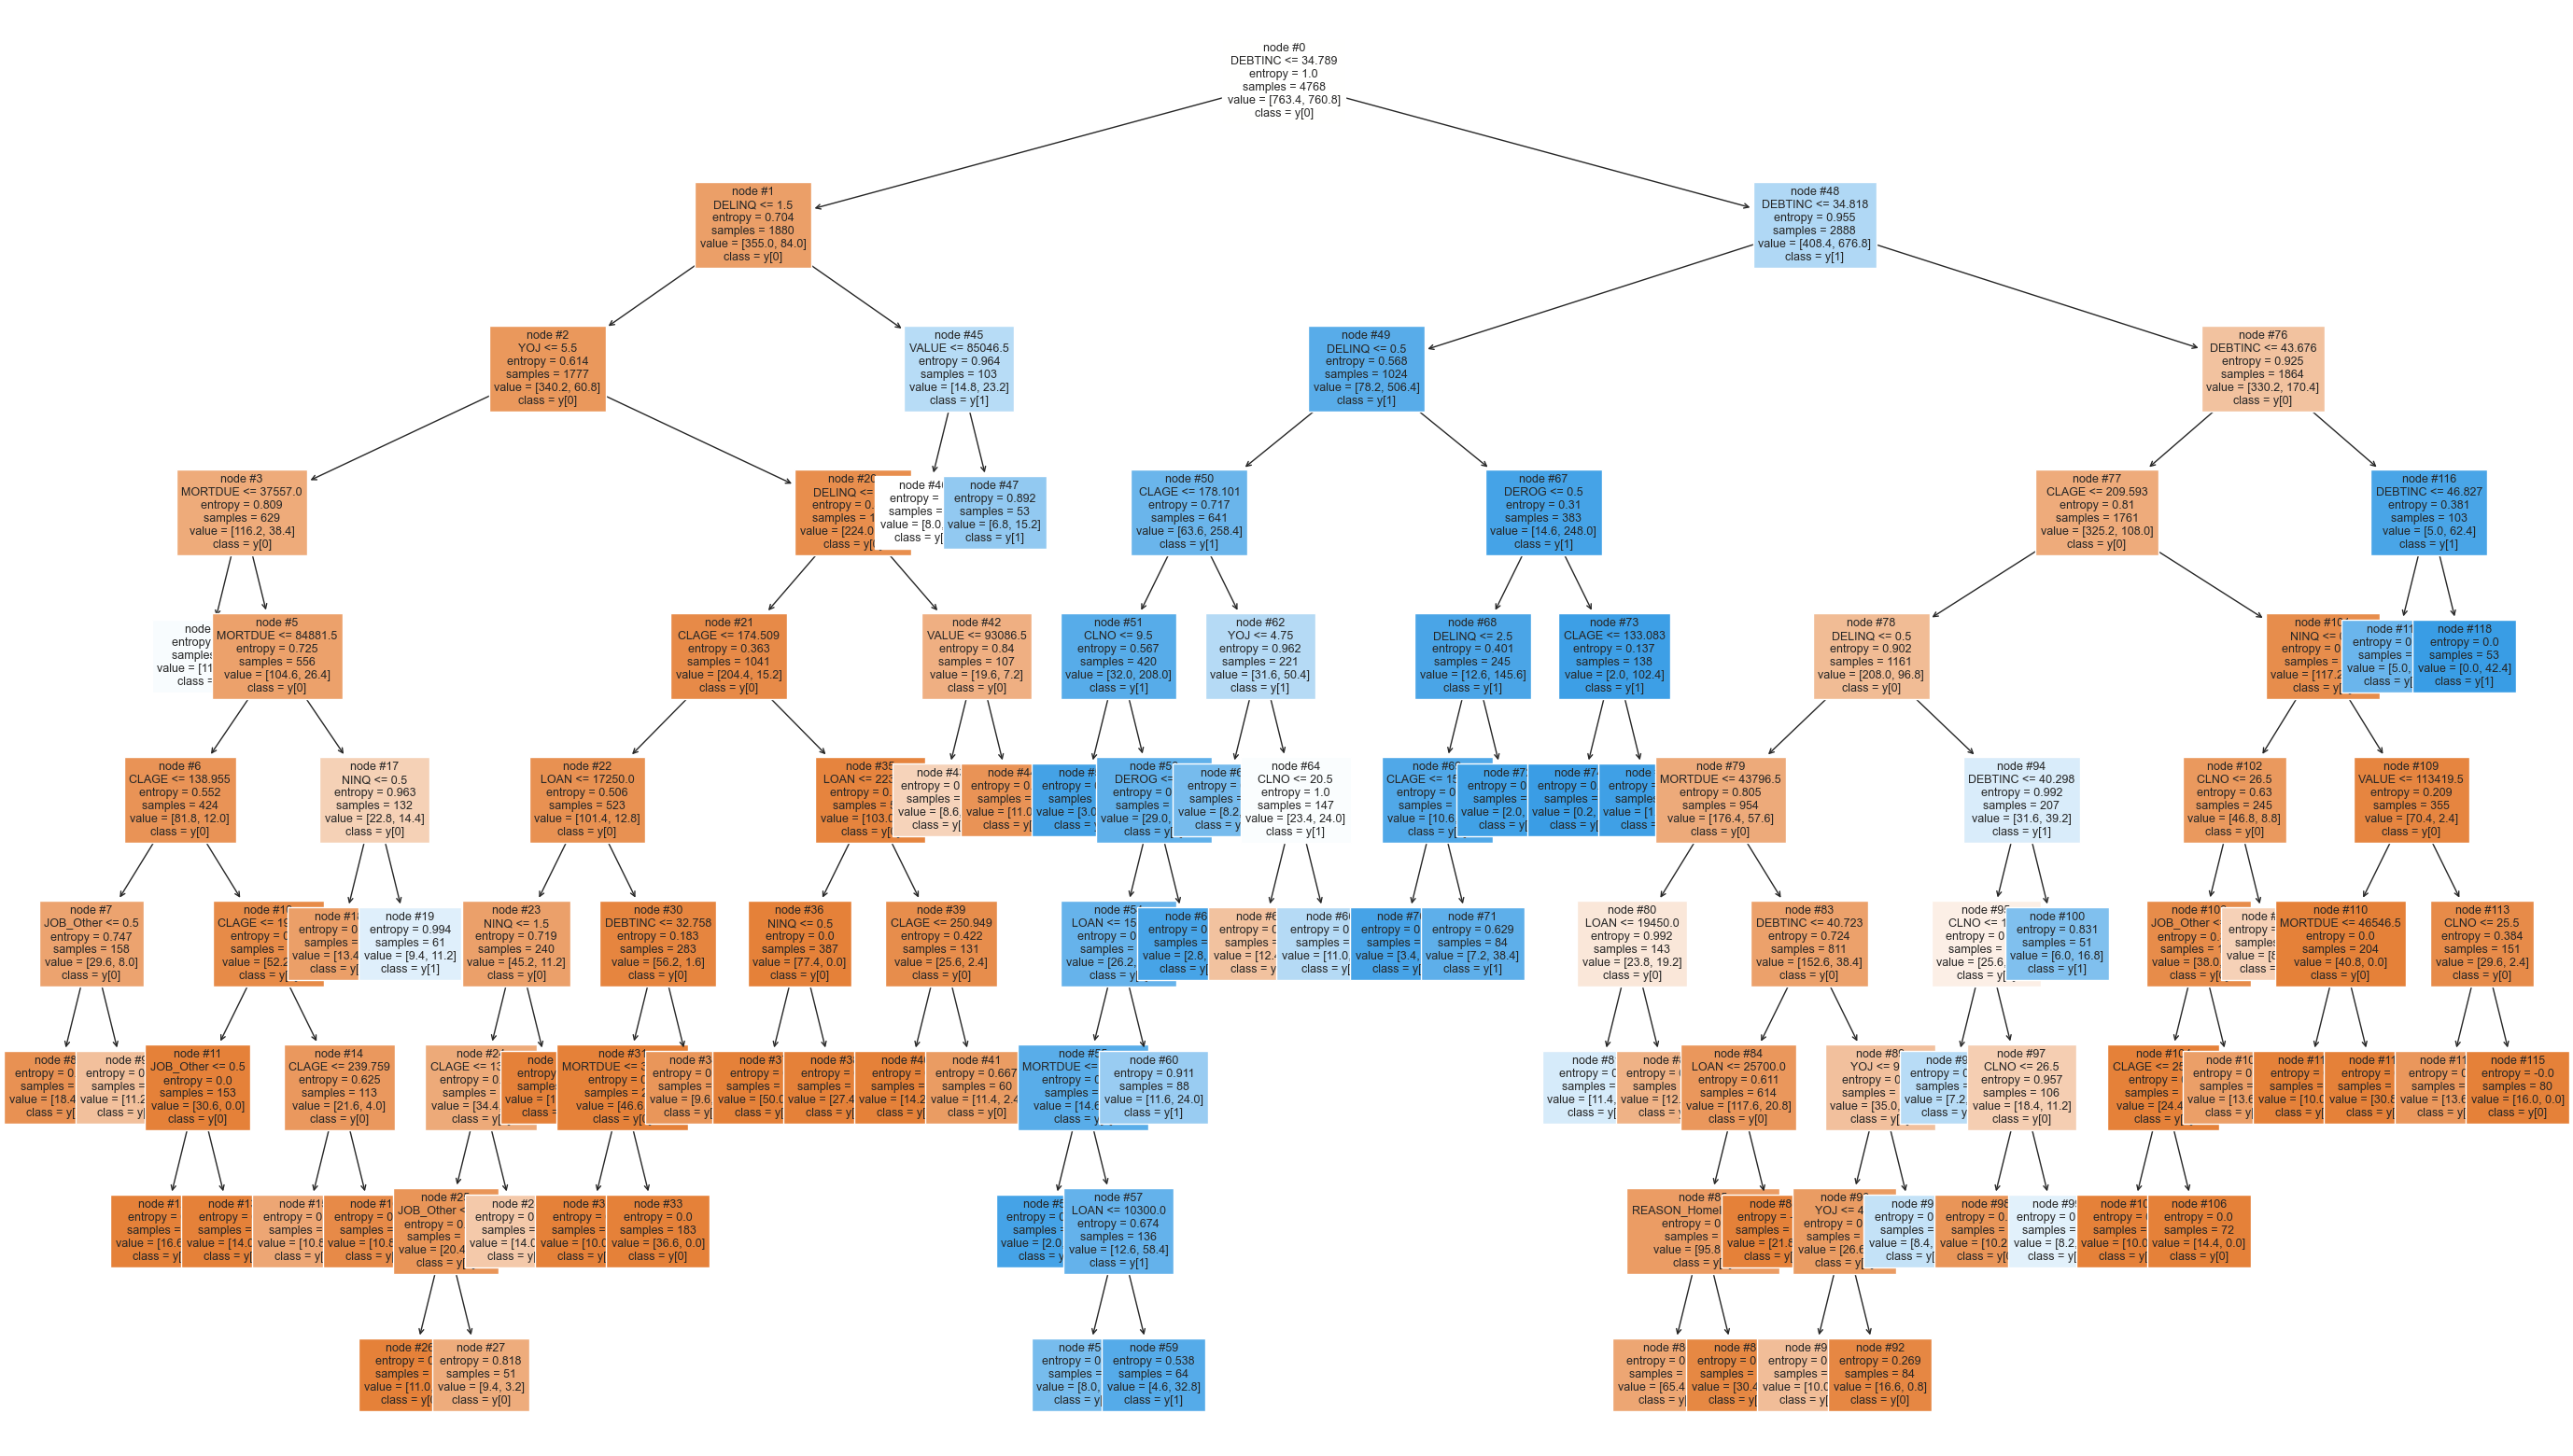

In [78]:
features = list(X.columns)

plt.figure(figsize = (35, 20))

tree.plot_tree(dtree_estimator, feature_names = features, filled = True, fontsize = 9, node_ids = True, class_names = True)

plt.show()


**Observations:** Based on the illustration individuals who have a Debt to income ratio of 37.101 or less, 1 deliquent credit line or less, a loan greater then 12,400 or a debt to income ratio greater then 12.4 are likely to not default.

Individuals with 1 or more deliquent credit lines and derogatory reports seems to be most likely to default.


Note: Blue leaves represent the individuals who defaulted, i.e., y[1], while the orange leaves represent the individuals who did not default, i.e., y[0]. Also, the more the number of observations in a leaf, the darker its color gets.

### **Building a Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample a decision tree makes a prediction.

**The results from all the decision trees are combined together and the final prediction is made using voting or averaging.**

In [79]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight = {0: 0.20, 1: 0.80}, random_state = 1)

rf_estimator.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      1.00      1.00       951

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768



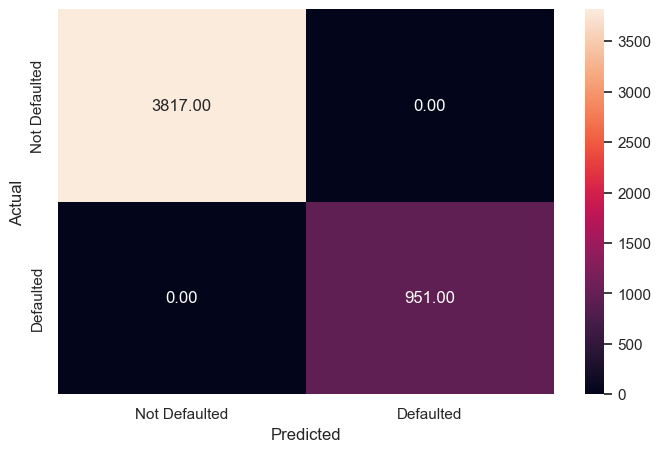

In [80]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

**Observation:**

Similarly to the first decsion tree The Random Forest is giving a 100% score for all metrics on the training dataset.

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       954
           1       0.86      0.63      0.73       238

    accuracy                           0.91      1192
   macro avg       0.89      0.80      0.84      1192
weighted avg       0.90      0.91      0.90      1192



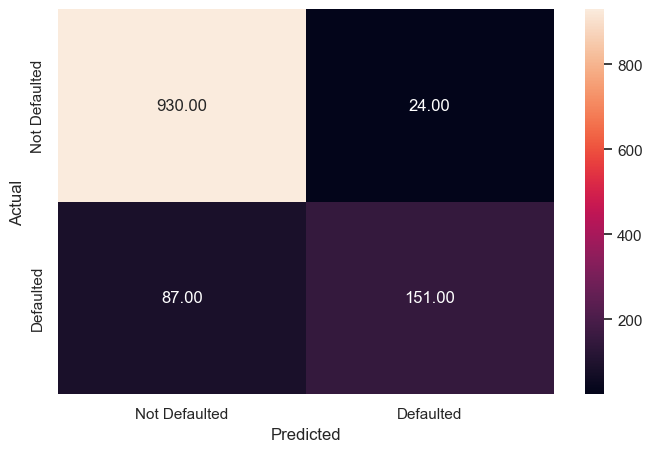

In [81]:
y_pred_test_rf = rf_estimator.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [82]:
rf_estimator_test = model_performance_classification(rf_estimator,x_test,y_test)
rf_estimator_test

,Precision,Recall,Accuracy
0,0.88866,0.80465,0.90688


**Observations:** This model has achieved the highest overall accuracy thus far at 90%. However, compared to the tuned decision tree the class 1 recall has gone down from 79% to 60% but our precision has gone up to 86%. Lets see if by hypertuning the recall value can get better.

### **Random Forest Classifier Hyperparameter Tuning**

In [92]:
# Choose the type of classifier This takes about 28 min to run
rf_estimator_tuned = RandomForestClassifier(criterion = "entropy", random_state = 1)

# Grid of parameters to choose from
params_rf = {"n_estimators": [100, 150, 200],
    "max_depth": [3, 4, 5, 6],
    "min_samples_leaf": [5, 10, 20, 50],
    "max_features": [0.8, 0.9],
    "max_samples": [0.9, 1],
    "class_weight": ["balanced",{0: 0.2, 1: 0.8}]
             }


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=0.8, max_samples=0.9,
                       min_samples_leaf=50, n_estimators=150, random_state=1)

**Observations:** From the grid search function it can be seen that the optimized parameters are a max depth of 6, max features of 0.9, max samples of 0.9, min sample leaf of 50, and to weight the classes.

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      3817
           1       0.63      0.81      0.71       951

    accuracy                           0.87      4768
   macro avg       0.79      0.85      0.81      4768
weighted avg       0.89      0.87      0.87      4768



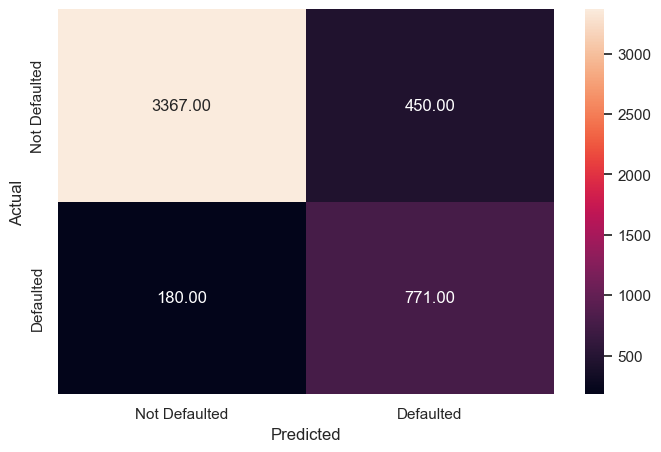

In [93]:
# Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)

metrics_score(y_train, y_pred_train_rf_tuned)

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       954
           1       0.60      0.76      0.67       238

    accuracy                           0.85      1192
   macro avg       0.77      0.82      0.79      1192
weighted avg       0.87      0.85      0.86      1192



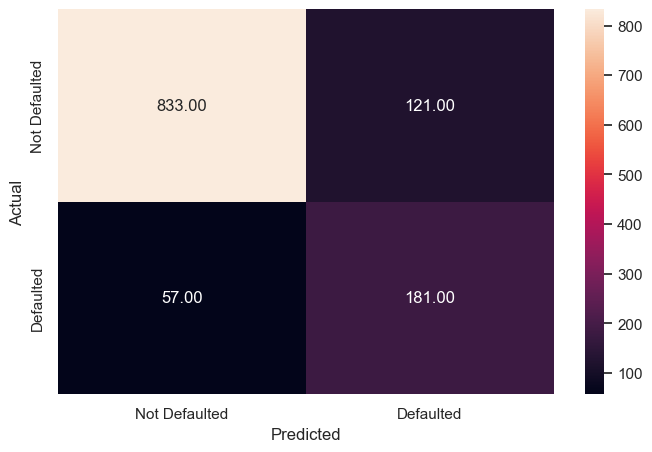

In [94]:
# Checking performance on the test data
y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)

metrics_score(y_test, y_pred_test_rf_tuned)

In [85]:
rf_estimator_tuned_test = model_performance_classification(rf_estimator_tuned,x_test,y_test)
rf_estimator_tuned_test

,Precision,Recall,Accuracy
0,0.75117,0.80372,0.83725


**Observations:** Compared to the untuned random forest the accuracy has decreased to 84% however the recall for class 1 has increased to 77%. Our overall precision has decreased to 77% from 87%.

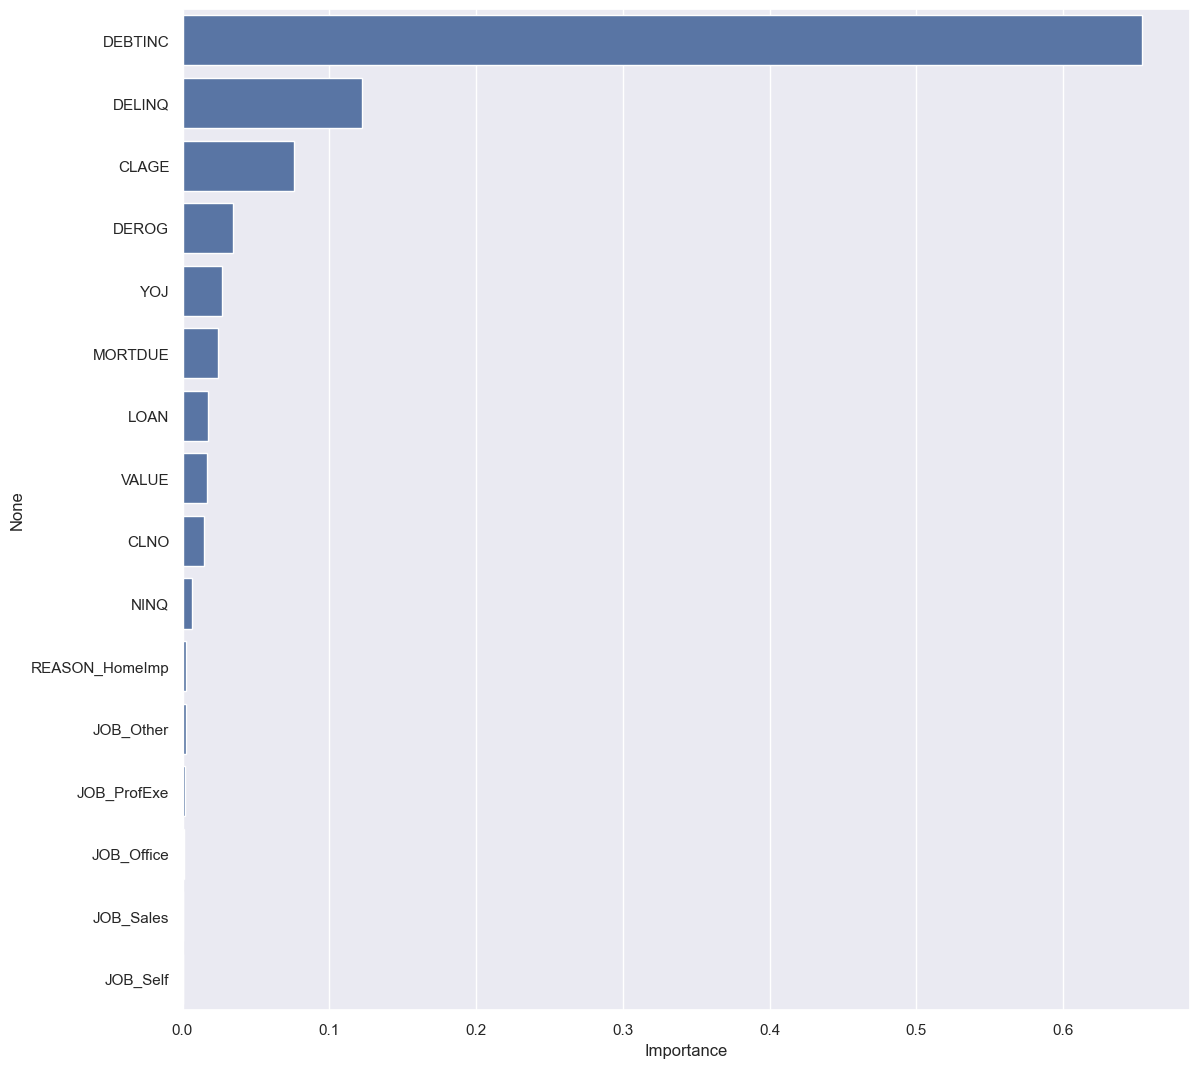

In [46]:
# Plotting feature importance
importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x=importance_df.Importance, y=importance_df.index);

**Observations:** Similar to the decision tree debt to income ratio is the most important feature by a significant margin.

Comparing the performance of all models

In [95]:
models_test_comp_df = pd.concat(

    [
    lg_model_Test.T,d_tree_test.T,dtree_estimator_test.T,rf_estimator_test.T,
    rf_estimator_tuned_test.T
    ],

    axis = 1,
)

models_test_comp_df.columns = [

 "Logisitic Regression Classifier",
    "Decision Tree classifier",
    "Tuned Decision Tree classifier",
    "Random Forest classifier",
    "Tuned Random Forest classifier"

]

In [96]:
print("Test performance comparison:")
models_test_comp_df

Test performance comparison:


,Logisitic Regression Classifier,Decision Tree classifier,Tuned Decision Tree classifier,Random Forest classifier,Tuned Random Forest classifier
Precision,0.58482,0.79740,0.73197,0.88866,0.75117
Recall,0.63173,0.77213,0.81165,0.80465,0.80372
Accuracy,0.60990,0.86745,0.81208,0.90688,0.83725


In [51]:
# Importing the AdaBoostClassifier and GradientBoostingClassifier [Boosting]
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost
# Importing the XGBClassifier from the xgboost library
from xgboost import XGBClassifier

print(xgboost.__version__)


2.1.3


In [88]:
#XGBoost Classifier
xgb_model = XGBClassifier(
    random_state=1, 
    eta=0.1,  # Lower learning rate for better tuning
    booster='gbtree', 
    max_depth=6,  # Reasonable tree depth
    min_child_weight=1,  # Integer value, typically >= 1
    tree_method="auto", 
    max_delta_step=0
)

# Fitting the model
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3817
           1       0.98      0.87      0.92       951

    accuracy                           0.97      4768
   macro avg       0.97      0.93      0.95      4768
weighted avg       0.97      0.97      0.97      4768



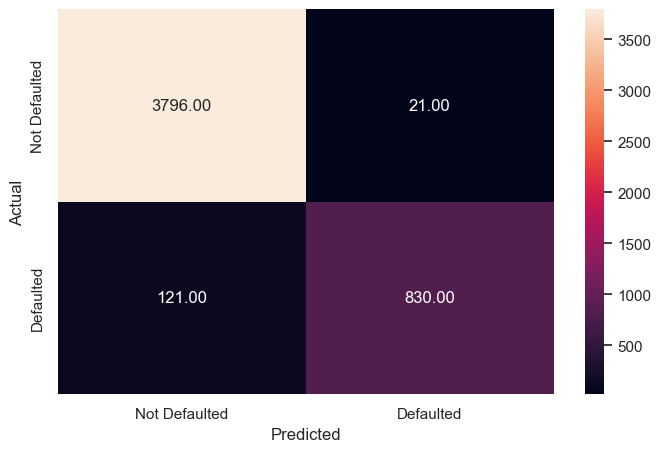

In [89]:
xgb_train = xgb_model.predict(x_train)

metrics_score(y_train, xgb_train)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       954
           1       0.84      0.68      0.75       238

    accuracy                           0.91      1192
   macro avg       0.88      0.82      0.85      1192
weighted avg       0.91      0.91      0.91      1192



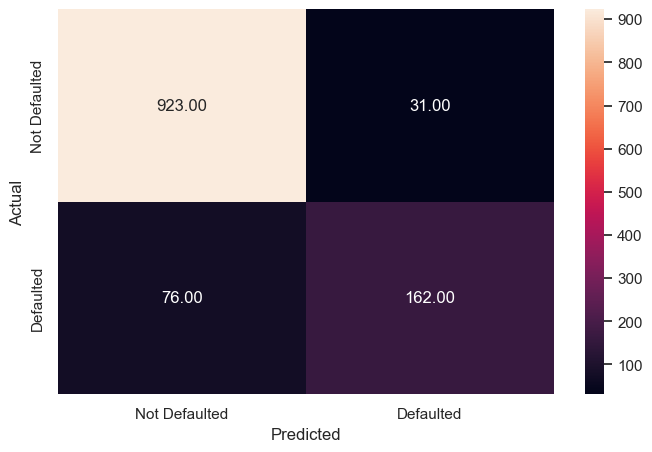

In [90]:
xgb_test = xgb_model.predict(x_test)

metrics_score(y_test, xgb_test)

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success):**

*   Based on the table above it can be seen that the default random forest model had the highest accuracy while the logistic regression model had the lowest. Digging deeper we can see that the tuned random forest model has the highest overal recall. The tuned decision tree had the best class 1 recall of 78% while the tuned random forest had a class 1 recall of 77%. That being said I would use the tuned random forest model as the one to use in order to predict if someone will default on their loan or not as it has the second highest class 1 recall of 77% while still maintaining good overall accuracy of 85%. The decision trees also can be used to interpret the outcome of the model by visualizing the breakdown of how the decision was made. This could help the bank find reasons as to why someone might default.

**2. Refined insights:**
- Since debt to income ratio is the most important feature when determining if someone is going to default or not it does not help that almost a quarter of individuals are missing this value. For this model we used median to fill those missing values but that may not be a good representation of the data. Other important features were DELINQ and CLAGE that had 10% and 5% of their data missing respectiviley so filling those values as well could be valuable. Also, rouglhy 68% of the data set put their job as other. This doesn't really help us in grouping people based on their job. If future data is to be gathered perhaps adding more job categories would help refine the models or help find some correlation. Similar story could be said about REASON as well as there is only two options.

**3. Proposal for the final solution design:**
- The model I would propose to adopt is the tuned random forest model as the one to use in order to predict if someone will default on their loan or not as it has the second highest class 1 recall of 77% while still maintaining good overall accuracy of 85%. That being said you could utilize other models depending on the current circumstances. If the bank is in a position to take on more risk then utilizing the default random forest model may be better as its overall accuracy was the highest at 89% and was better at predicting people who would not default. Therefore you would capture more people as paying back the loan thus giving out more loans and making more money in interest. It would come at a cost of failing to identify the defaulters though.